# 이미지 전처리 

In [2]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

In [3]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

In [4]:
Dataset = namedtuple('Dataset',['X','y'])

In [5]:
def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath,n_labels,resize_to):
    images = []
    labels = []
    
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        for img_name in glob.glob(full_path + "*.ppm"):
            
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img/255.0)[:,:,0]
            if resize_to:
                img = resize(img, resize_to, mode='reflect')
                
            label = np.zeros((n_labels,),dtype=np.float32)
            label[c] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32),
                  y = np.matrix(labels).astype(np.float32))

In [6]:
dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


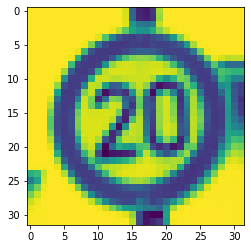

In [7]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[0, :]) #label

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


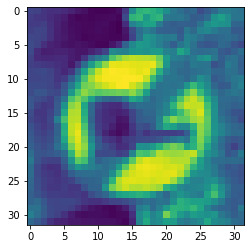

In [8]:
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[-1, :]) #label

In [9]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]),test_size=0.25, random_state = 101)
X_train = dataset.X[idx_train,:,:,:]
X_test = dataset.X[idx_test,:,:,:]
y_train = dataset.y[idx_train,:]
y_test = dataset.y[idx_test,:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


# 모델 생성 

In [10]:
import tensorflow as tf
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and ‘any'.

In [11]:
tf.__version__

'2.4.0-rc0'

In [12]:
batch_size = 156
learning_rate = 0.001
epochs_size = 10

In [13]:
X_train.shape

(29406, 32, 32, 1)

In [14]:
X_train[0, 0, 0, 0]

100.0

In [15]:
model = tf.keras.Sequential()

#convloution,pooling,dropout layer
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),input_shape=(32,32,1),padding='same' ))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same' ))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(tf.keras.layers.Dropout(0.2))

#flatten, fully connected, dropout layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=43,kernel_initializer='glorot_uniform',bias_initializer='zeros',activation='softmax'))

"""
It can't be possible to use droptout before the softmax layer.
softmax use sum of the all nodes and one-hot encoding.
but dropout before the softmax layer chooses some of the nodes randomly, so there is different meaning
every epoch the model uses dropout and softmax.
So, you must add one layer after using dropout or delete your last dropout layer.

"""
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

# 모델 훈련 

In [16]:
history = model.fit(X_train, y_train, epochs = epochs_size, batch_size = batch_size)

Epoch 1/10


2021-09-17 11:16:44.799581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 11:16:44.799845: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


189/189 [==============================] - 8s 42ms/step - loss: 0.2865 - accuracy: 0.1993
Epoch 2/10
189/189 [==============================] - 8s 41ms/step - loss: 0.0473 - accuracy: 0.7017
Epoch 3/10
189/189 [==============================] - 8s 41ms/step - loss: 0.0271 - accuracy: 0.8517
Epoch 4/10
189/189 [==============================] - 8s 40ms/step - loss: 0.0189 - accuracy: 0.9108
Epoch 5/10
189/189 [==============================] - 8s 41ms/step - loss: 0.0142 - accuracy: 0.9419
Epoch 6/10
189/189 [==============================] - 8s 40ms/step - loss: 0.0109 - accuracy: 0.9580
Epoch 7/10
189/189 [==============================] - 8s 40ms/step - loss: 0.0095 - accuracy: 0.9648
Epoch 8/10
189/189 [==============================] - 8s 40ms/step - loss: 0.0077 - accuracy: 0.9743
Epoch 9/10
189/189 [==============================] - 8s 40ms/step - loss: 0.0072 - accuracy: 0.9770
Epoch 10/10
189/189 [==============================] - 8s 41ms/step - loss: 0.0063 - accuracy: 0.9794


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
evaluation = model.evaluate(X_test,y_test)
print("TEST SET PERFORMANCE")
print("test loss: ",evaluation[0])
print("test accuracy: ",evaluation[1])

307/307 [==============================] - 6s 18ms/step - loss: 0.0039 - accuracy: 0.9889
TEST SET PERFORMANCE
test loss:  0.0038692497182637453
test accuracy:  0.9888809323310852


In [18]:
prediction = model.predict(X_test)
y_predict = np.argmax(prediction,axis=1)
y_true = np.argmax(y_test,axis=1)
y_true = (np.asarray(y_true).flatten())
print(classification_report(y_true,y_predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        67
           1       0.97      0.99      0.98       539
           2       0.98      0.99      0.99       558
           3       1.00      0.96      0.98       364
           4       1.00      0.99      0.99       487
           5       0.98      0.95      0.97       479
           6       0.99      0.99      0.99       105
           7       0.99      0.98      0.99       364
           8       0.97      1.00      0.98       340
           9       1.00      0.99      0.99       384
          10       0.99      1.00      1.00       513
          11       0.99      0.99      0.99       334
          12       0.99      0.99      0.99       545
          13       0.99      1.00      0.99       537
          14       1.00      1.00      1.00       213
          15       0.93      0.99      0.96       164
          16       1.00      1.00      1.00        98
          17       0.99    

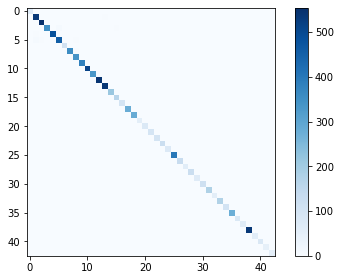

In [19]:
cm = confusion_matrix(y_true,y_predict)

plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.show()

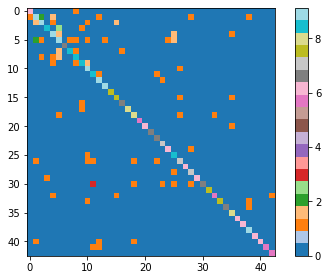

In [19]:
plt.imshow(np.log2(cm+1),interpolation='nearest',cmap=plt.get_cmap("tab20"))
plt.colorbar()
plt.tight_layout()
plt.show()

# 시각화하기  

In [58]:
class_names = ['속도제한20','속도제한30','속도제한50','속도제한60','속도제한70','6','7',
               '8','9','10','11','12','13','14','15','16','17','18','19',
               '20','21','22','23','24','25','26','27','28','29','30','31',
               '32','33','34','35','36','37','38','39','40','41','42','43']

In [59]:
def plot_image(i,prediction,y_predict,y_true,image):
    prediction,y_predict,y_true,image = prediction[i],y_predict[i],y_true[i],image[i]
    image = image.reshape(32,32)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(image, cmap=plt.cm.binary)
    if y_predict == y_true:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[y_predict],
                                        100*np.max(prediction),
                                        class_names[y_true]),
                                        color = color)

def plot_value_array(i,predictions,y_predict,y_true):
    predictions,y_predict,y_true = predictions[i],y_predict[i],y_true[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(43),predictions,color="#777777")
    plt.ylim([0, 1])
    predicted_label = y_predict
    
    thisplot[predicted_label].set_color('red')
    thisplot[y_true].set_color('blue')

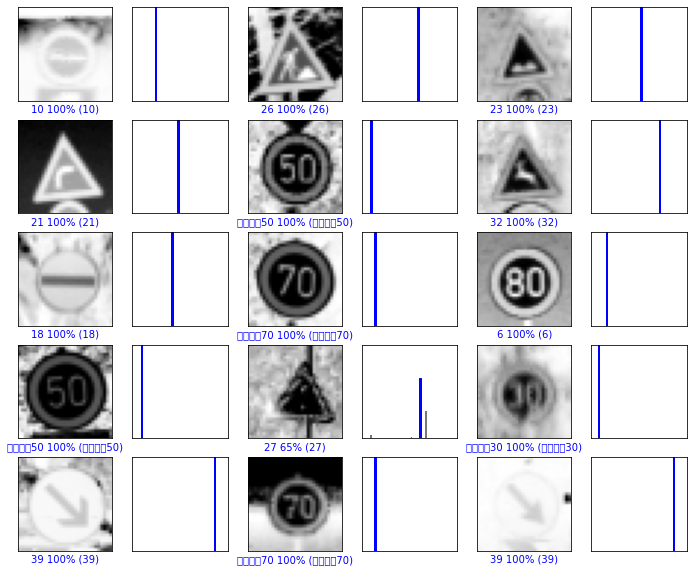

In [61]:
import random

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    r = np.random.randint(0,y_true.shape[0])
   
    
    plt.subplot(num_rows,2*num_cols, 2*i+1)
    plot_image(r, prediction,y_predict, y_true, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(r,prediction,y_predict, y_true)

plt.show()